# Boston House Prices

I'm going to build a model that summarizes the relationship between many variables and the price of a house. `sklearn` has some built in datasets and the boston house price dataset is one of them. Each record is a neighborhood and I'm going to focus on the following columns:

| Column Name | Description                                            |
|-------------|--------------------------------------------------------|
| CRIM        | per capita crime rate by town                          |
| price       | Median value of owner-occupied homes in \\$1,000        |
| TAX         | full-value property-tax rate per $10,000               |
| AGE         | proportion of owner-occupied units built prior to 1940 |
| RM          | average number of rooms per dwelling                   |
| PTRATIO     | pupil-teacher ratio by town                            |

Now I'll load the data.

In [38]:
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn.datasets import load_boston

from housing import load
from housing import featureCreate
from housing import investigate
from housing import model

importlib.reload(load);
importlib.reload(featureCreate);
importlib.reload(investigate);
importlib.reload(model);

df = load.importDat(['CRIM', 'price', 'TAX', 'AGE', 'RM', 'PTRATIO'])
df.describe()

,CRIM,price,TAX,AGE,RM,PTRATIO
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,22.532806,408.237154,68.574901,6.284634,18.455534
std,8.601545,9.197104,168.537116,28.148861,0.702617,2.164946
min,0.006320,5.000000,187.000000,2.900000,3.561000,12.600000
25%,0.082045,17.025000,279.000000,45.025000,5.885500,17.400000
50%,0.256510,21.200000,330.000000,77.500000,6.208500,19.050000
75%,3.677083,25.000000,666.000000,94.075000,6.623500,20.200000
max,88.976200,50.000000,711.000000,100.000000,8.780000,22.000000


This dataset has 506 rows and the above table contains some descriptive statistics.

- Average crime rate is around 3.6 crimes per person and the maximum was 88.97
- Median price of a house is around 2253, and the maximum observed price was 50k. 
- Average amount of tax per 10000 in value is 408
- Around 68% of houses were built prior to 1940, and there are some neighborhoods that are entirely made up of houses built prior to 1940.
- Most houses have around 6 rooms, and there isn't a lot of variation in that.
- The average pupil-teacher ratio is 18, which seems fairly low in my view.

No I'll do a quick check for missing values...

In [2]:
df.isna().sum()

CRIM       0
price      0
TAX        0
AGE        0
RM         0
PTRATIO    0
dtype: int64

Looks good! Now lets take a look at the distributions of the pairs of variables.

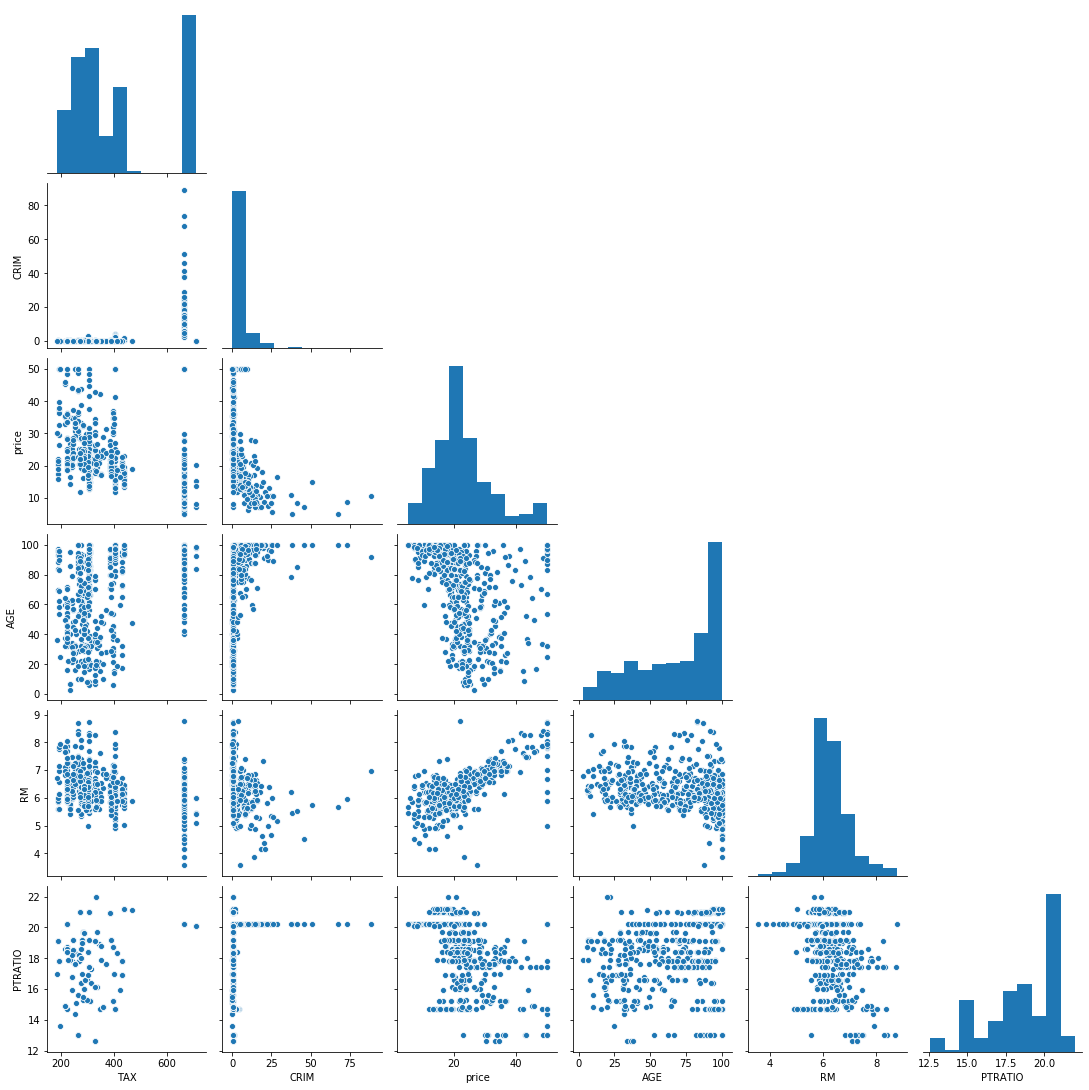

In [3]:
sns.pairplot(df[['TAX', 'CRIM', 'price', 'AGE', 'RM', 'PTRATIO']], corner=True);

A couple notes

- Tax rate is wonky (scatter with ptratio)
- RM looks fairly normally distributed (skinny tails)
- AGE is definitely left skewed. (lots of old houses in boston!)
- Price and RM are positively correlated (this is good to see)
- PRATIO and TAX

In [10]:
investigate.taxPratio(df)

Investigate the weird scatter plot between tax and ptratio.


,TAX,PTRATIO,count
0,666.0,20.2,132
1,711.0,20.1,5


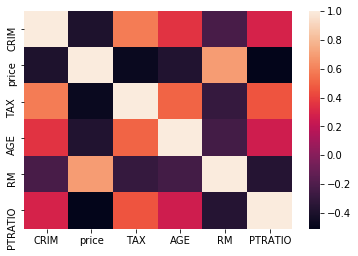

In [12]:
sns.heatmap(df.corr());

## Modeling

In [25]:
olsModel = model.slr(df,
                      xVars=[x for x in df.columns if x != 'price'],
                      yVar='price')
print(olsModel.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              1713.
Date:                Sat, 14 Mar 2020   Prob (F-statistic):                   2.54e-312
Time:                        13:32:51   Log-Likelihood:                         -1600.4
No. Observations:                 506   AIC:                                      3211.
Df Residuals:                     501   BIC:                                      3232.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [26]:
logModel = model.slr(
    featureCreate.logVars(df, ['price']),
    xVars = [x for x in df.columns if x not in ['price', 'log_price']],
    yVar='log_price'
)
print(logModel.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_price   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.129e+04
Date:                Sat, 14 Mar 2020   Prob (F-statistic):                        0.00
Time:                        13:32:51   Log-Likelihood:                         -86.629
No. Observations:                 506   AIC:                                      183.3
Df Residuals:                     501   BIC:                                      204.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

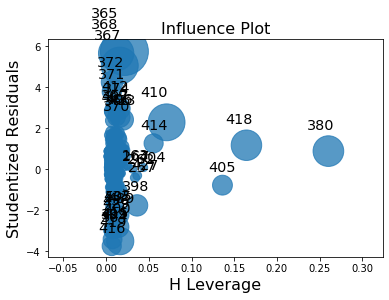

In [39]:
model.getPlot(logModel)

In [51]:
model.getDFB(logModel).query('hat_diag > .15')

,dfb_CRIM,dfb_TAX,dfb_AGE,dfb_RM,dfb_PTRATIO,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
380,0.507084,-0.179089,-0.034777,0.110979,-0.017379,0.052849,0.866590,0.260282,0.514046,0.866374,0.513918
418,0.500690,-0.180215,-0.013853,0.066250,0.012719,0.052255,1.152739,0.164316,0.511152,1.153118,0.511320


In [43]:
df.iloc[418]

CRIM        73.5341
price        8.8000
TAX        666.0000
AGE        100.0000
RM           5.9570
PTRATIO     20.2000
Name: 418, dtype: float64

In [40]:
df.iloc[380]

CRIM        88.9762
price       10.4000
TAX        666.0000
AGE         91.9000
RM           6.9680
PTRATIO     20.2000
Name: 380, dtype: float64